In [1]:
import tensorflow as tf
import tensorflow.keras as tf_keras
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 

class OptimizedMultiQueryAttentionLayerWithDownSampling(tf_keras.layers.Layer):
  """Multi Query Attention with spatial downsampling.

   3 parameters are introduced for the spatial downsampling:
   1. kv_strides: downsampling factor on Key and Values only.
   2. query_h_strides: vertical strides on Query only.
   3. query_w_strides: horizontal strides on Query only.

  This is an optimized version.
  1. Projections in Attention is explict written out as 1x1 Conv2D.
  2. Additional reshapes are introduced to bring a up to 3x speed up.
  """

  def __init__(
      self,
      num_heads: int,
      key_dim: int,
      value_dim: int,
      query_h_strides: int = 1,
      query_w_strides: int = 1,
      kv_strides: int = 1,
      dropout: float = 0,
      dw_kernel_size: int = 3,
      use_sync_bn: bool = False,
      norm_momentum: float = 0.99,
      norm_epsilon: float = 0.001,
  ):
    """Initializer.

    Args:
      num_heads: Number of attention heads.
      key_dim: Size of the attention key dimension.
      value_dim: Size of the attention value dimension.
      query_h_strides: Vertical stride size for query only.
      query_w_strides: Horizontal stride size for query only.
      kv_strides: Key and value stride size.
      dropout: Dropout probability (between 0 and 1).
      dw_kernel_size: Spatial dimension of the depthwise kernel.
      use_sync_bn: If True, use synchronized batch normalization.
      norm_momentum: Momentum value for use with normalization moving average.
      norm_epsilon: Small float added to norm variance to avoid dividing by
        zero.
    """
    super().__init__()
    self._num_heads = num_heads
    self._key_dim = key_dim
    self._value_dim = value_dim
    self._query_h_strides = query_h_strides
    self._query_w_strides = query_w_strides
    self._kv_strides = kv_strides
    self._dw_kernel_size = dw_kernel_size
    self._dropout = dropout
    self._norm_momentum = norm_momentum
    self._norm_epsilon = norm_epsilon

    if use_sync_bn:
      self._norm = tf_keras.layers.experimental.SyncBatchNormalization
    else:
      self._norm = tf_keras.layers.BatchNormalization
    if tf_keras.backend.image_data_format() == 'channels_last':
      self._bn_axis = -1
    else:
      self._bn_axis = 1

  def build(self, input_shape):
    """Create layer state."""
    self._channel_dim = input_shape[-1]

    if self._query_h_strides > 1 or self._query_w_strides > 1:
      self._query_downsampling = tf_keras.layers.AvgPool2D(
          pool_size=(self._query_h_strides, self._query_w_strides),
          padding='same',
      )
      self._query_downsampling_norm = self._norm(
          axis=self._bn_axis,
          momentum=self._norm_momentum,
          epsilon=self._norm_epsilon,
      )

    self._query_proj = tf_keras.layers.Conv2D(
        filters=self._num_heads * self._key_dim,
        kernel_size=1,
        strides=1,
        padding='valid',
        use_bias=False,
    )

    if self._kv_strides > 1:
      self._key_dw_conv = tf_keras.layers.DepthwiseConv2D(
          kernel_size=self._dw_kernel_size,
          strides=self._kv_strides,
          padding='same',
          depth_multiplier=1,
          use_bias=False,
      )
      self._key_dw_norm = self._norm(
          axis=self._bn_axis,
          momentum=self._norm_momentum,
          epsilon=self._norm_epsilon,
      )
    self._key_proj = tf_keras.layers.Conv2D(
        filters=self._key_dim,
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
    )

    if self._kv_strides > 1:
      self._value_dw_conv = tf_keras.layers.DepthwiseConv2D(
          kernel_size=self._dw_kernel_size,
          strides=self._kv_strides,
          padding='same',
          depth_multiplier=1,
          use_bias=False,
      )
      self._value_dw_norm = self._norm(
          axis=self._bn_axis,
          momentum=self._norm_momentum,
          epsilon=self._norm_epsilon,
      )
    self._value_proj = tf_keras.layers.Conv2D(
        filters=self._value_dim,
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
    )

    self._output_proj = tf_keras.layers.Conv2D(
        filters=self._channel_dim,
        kernel_size=1,
        strides=1,
        padding='valid',
        use_bias=False,
    )
    if self._query_h_strides > 1 or self._query_w_strides > 1:
      self._upsampling = tf_keras.layers.UpSampling2D(
          size=(self._query_h_strides, self._query_w_strides),
          interpolation='bilinear',
      )
    self._dropout_layer = tf_keras.layers.Dropout(rate=self._dropout)

  def _reshape_input(self, t):
    """Reshapes a tensor to three dimensions, keeping the first and last."""
    s = tf.shape(t)
    # Propagate the shape statically where possible.
    static_num = t.shape[1:-1].num_elements()
    num = static_num or tf.math.reduce_prod(s[1:-1])
    return tf.ensure_shape(
        tf.reshape(t, [s[0], num, s[-1]]), [t.shape[0], static_num, t.shape[-1]]
    )

  def _reshape_projected_query(self, t, num_heads, h_px, w_px, key_dim):
    """Reshapes projected query: [b, n, n, h x k] -> [b, n x n, h, k]."""
    s = tf.shape(t)
    return tf.reshape(t, [s[0], h_px * w_px, num_heads, key_dim])

  def _get_pixels(self, t):
    s = tf.shape(t)
    static_num = t.shape[1]
    px = static_num or s[1]
    return px

  def _reshape_output(self, t, num_heads, h_px, w_px):
    """Reshape output:[b, n x n x h, k] -> [b, n, n, hk]."""
    s = tf.shape(t)
    # Propagate the shape statically where possible.
    static_last_dim = t.shape[-1]
    last_dim = (static_last_dim or s[-1]) * num_heads
    return tf.reshape(t, [t.shape[0] or s[0], h_px, w_px, last_dim])

  def call(self, inputs):
    """Run layer computation."""
    x = inputs
    px = self._get_pixels(x)

    if self._query_h_strides > 1 or self._query_w_strides > 1:
      q = self._query_downsampling(x)
      q = self._query_downsampling_norm(q)
      q = self._query_proj(q)
    else:
      q = self._query_proj(x)

    # desired q shape: [b, n x n, h, k] - [b, l, h, k]
    q = self._reshape_projected_query(
        q,
        self._num_heads,
        px // self._query_h_strides,
        px // self._query_w_strides,
        self._key_dim,
    )

    if self._kv_strides > 1:
      k = self._key_dw_conv(x)
      k = self._key_dw_norm(k)
      k = self._key_proj(k)
    else:
      k = self._key_proj(x)
    # output shape of k: [b, k, p], p = m x m
    k = self._reshape_input(k)

    # desired q shape: [b, n x n, h, k]
    # desired k shape: [b, m x m, k]
    # desired logits shape: [b, n x n, h, m x m]
    logits = tf.einsum('blhk,bpk->blhp', q, k)

    logits = logits / tf.math.sqrt(tf.cast(self._key_dim, x.dtype))

    attention_scores = self._dropout_layer(tf.nn.softmax(logits))

    if self._kv_strides > 1:
      v = self._value_dw_conv(x)
      v = self._value_dw_norm(v)
      v = self._value_proj(v)
    else:
      v = self._value_proj(x)

    # output shape of v: [ b, p, k], p = m x m
    v = self._reshape_input(v)
    o = tf.einsum('blhp,bpk->blhk', attention_scores, v)
    # reshape o into [b, n, n, hk]
    o = self._reshape_output(
        o,
        self._num_heads,
        px // self._query_h_strides,
        px // self._query_w_strides,
    )
    if self._query_h_strides > 1 or self._query_w_strides > 1:
      o = self._upsampling(o)

    result = self._output_proj(o)

    return tf.ensure_shape(tf.reshape(result, tf.shape(x)), x.shape)

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

def analyze(model):
    print('='*21, ' Model Info', '='*21)
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('Trainable params:',trainableParams)
    print('Nontrainable params:',nonTrainableParams)
    print('Total params:', totalParams)
    print('Flops:', get_flops(model))
    print('='*21, 'End of Info', '='*21)


2024-08-11 08:21:14.779794: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
inp = 4
num_heads = 2
key_dim = 8
query_h_strides = 2
query_w_strides = 2

head_dim = key_dim // num_heads
n = 16
input_tensor = tf.zeros((1,n,n,inp))
batch_size, _, _, seq_length= tf.shape(input_tensor)
tf_keras.layers.Conv2D(7,3,padding='same')(input_tensor).shape


TensorShape([1, 16, 16, 7])

In [3]:
attn = OptimizedMultiQueryAttentionLayerWithDownSampling(num_heads,key_dim,key_dim,query_h_strides,query_w_strides)

In [6]:
tf.shape(attn(input_tensor))

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 1, 16, 16,  4], dtype=int32)>

In [7]:
mha = tf_keras.layers.MultiHeadAttention(num_heads,key_dim,key_dim)

In [8]:
tf.shape(mha(input_tensor,input_tensor))

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 1, 16, 16,  4], dtype=int32)>

In [32]:
inp1 = tf_keras.Input((n,n,inp),1)
out1 = tf_keras.layers.MultiHeadAttention(num_heads,key_dim,key_dim)(inp1,inp1)
m1 = tf_keras.Model(inp1, out1)

analyze(m1)

=====================  Model Info =====================
Trainable params: 308
Nontrainable params: 0.0
Total params: 308.0

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belongi

2024-08-11 10:40:37.297908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:40:37.298031: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-08-11 10:40:37.298088: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-08-11 10:40:37.298288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:40:37.298425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:40:37.298546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] su

In [33]:
inp2 = tf_keras.Input((n,n,inp),1)
out2 = OptimizedMultiQueryAttentionLayerWithDownSampling(1,1,1,query_h_strides,query_w_strides,query_w_strides)(inp2)
m2 = tf_keras.Model(inp2, out2)

analyze(m2)

=====================  Model Info =====================
Trainable params: 112
Nontrainable params: 24
Total params: 136

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging 

2024-08-11 10:40:44.387216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:40:44.387374: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-08-11 10:40:44.387443: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-08-11 10:40:44.387641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:40:44.387783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:40:44.387903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] su

In [41]:
# tf.get_logger().setLevel('ERROR')
# tf.autograph.set_verbosity(3)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 
import logging
tf.get_logger().setLevel(logging.ERROR)

In [36]:
import tensorflow.keras.layers as layers

class DoubleSE_Block(tf.keras.layers.Layer):
    def __init__(self, reduction_factor=4, attn_strides=2, attn_kernel=3, **kwargs):
        super(DoubleSE_Block, self).__init__(**kwargs)
        self.reduction_factor = reduction_factor
        self.attn_strides = attn_strides
        self.attn_kernel = attn_kernel

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_factor': self.reduction_factor,
            'attn_strides': self.attn_strides,
            'attn_kernel': self.attn_kernel
        })
        return config

    def build(self, input_shape):
        input_size = int(input_shape[1])
        input_channels = int(input_shape[-1])
        self.pool = layers.GlobalAveragePooling2D()
        self.d1 = layers.Dense(input_channels//self.reduction_factor, activation='relu6')
        self.d2 = layers.Dense(input_channels, activation='hard_sigmoid')
        self.reshape = layers.Reshape((1, 1, input_channels))
        # self.reshape2 = layers.Reshape((input_size, input_size, 1))
        self.out = layers.Multiply()
        self.attn = OptimizedMultiQueryAttentionLayerWithDownSampling(1,1,1,self.attn_strides,self.attn_strides,self.attn_strides,dw_kernel_size=self.attn_kernel)

    def call(self, inputs):
        x1 = self.pool(inputs)
        x1 = self.d1(x1)
        x1 = self.d2(x1)
        x1 = self.reshape(x1)
        x1 = self.out([inputs, x1])
        x2 = tf.math.reduce_mean(inputs, -1,keepdims=True)
        x2 = self.attn(x2)
        return self.out([x1, x2])


In [40]:
inp3 = tf_keras.Input((16,16,32),1)
out3 = DoubleSE_Block(2)(inp3)
m3 = tf_keras.Model(inp3, out3)

analyze(m3)

=====================  Model Info =====================
Trainable params: 1100
Nontrainable params: 6
Total params: 1106

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging

2024-08-11 10:43:24.174461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:43:24.174588: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-08-11 10:43:24.174645: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-08-11 10:43:24.174823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:43:24.174959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 10:43:24.175079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] su

In [8]:
inp4 = tf_keras.Input((n,n,1),1)
out4 = layers.Conv2D(1,3,2)(inp4)
m4 = tf_keras.Model(inp4, out4)

analyze(m4)

=====================  Model Info =====================
Trainable params: 37
Nontrainable params: 0.0
Total params: 37.0

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging

2024-08-11 08:31:52.286902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 08:31:52.287044: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-08-11 08:31:52.287109: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-08-11 08:31:52.287259: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 08:31:52.287409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-11 08:31:52.287529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] su

In [17]:
tf.shape(tf.math.reduce_mean(input_tensor, -1,keepdims=True))

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 1, 16, 16,  1], dtype=int32)>

In [90]:
def regularization(alpha=0.8, beta=3, cap=25):
    def func(x):
        return tf.math.minimum(cap, tf.math.pow(alpha, -tf.math.abs(x)+beta)-tf.math.pow(alpha, beta)+1)
    return func

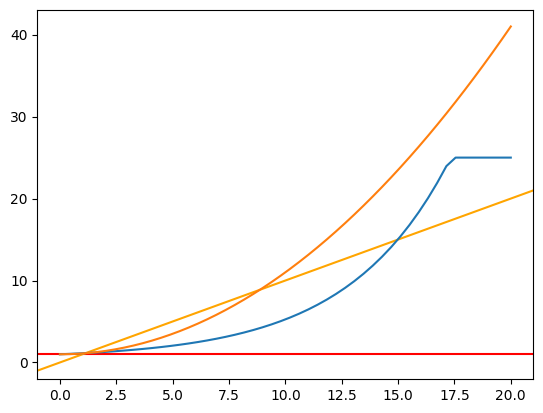

In [95]:
import matplotlib.pyplot as plt

x = np.linspace(0, 20, num=50).astype(np.float32)
plt.axhline(y=1, color = 'r', linestyle = '-') 
plt.axline((0,0),(1,1), color = 'orange', linestyle = '-') 
plt.plot(x, regularization()(x))
plt.plot(x, 0.1*(x**2)+1)